In [1]:
import os
import time
import torch
import random
import functions
import dataClass
import numpy as np
import numpy as np
import pandas as pd
import torch.nn as nn
from pesq import pesq
import torch.optim as optim
import matplotlib.pyplot as plt
from torchinfo import summary
from torch.utils.data import DataLoader

### Data Import

In [2]:
filepath = "./data_details.csv"
df = functions.read_csv_data(filepath)
df = df.iloc[:2500]
print(df.shape)
df.head()

(2500, 17)


Unnamed: 0  mixed     near_end     far_end1     far_end2  \
0           0  1.wav  FAEM0_1.wav  MGJC0_4.wav  MJRK0_3.wav   
1           1  2.wav  FAEM0_1.wav  MMCC0_2.wav  MPRK0_1.wav   
2           2  3.wav  FAEM0_1.wav  FBAS0_4.wav  MSEM1_2.wav   
3           3  4.wav  FAEM0_1.wav  MTJG0_1.wav  MWAR0_3.wav   
4           4  5.wav  FAEM0_1.wav  FEEH0_3.wav  MRDS0_2.wav   

           mixed_path                near_end_path  \
0  ./data/mixed/1.wav  ./data/near_end/FAEM0_1.wav   
1  ./data/mixed/2.wav  ./data/near_end/FAEM0_1.wav   
2  ./data/mixed/3.wav  ./data/near_end/FAEM0_1.wav   
3  ./data/mixed/4.wav  ./data/near_end/FAEM0_1.wav   
4  ./data/mixed/5.wav  ./data/near_end/FAEM0_1.wav   

                far_end1_path               far_end2_path near_end_loc  \
0  ./data/far_end/MGJC0_4.wav  ./data/far_end/MJRK0_3.wav    [2, 4, 1]   
1  ./data/far_end/MMCC0_2.wav  ./data/far_end/MPRK0_1.wav    [9, 1, 3]   
2  ./data/far_end/FBAS0_4.wav  ./data/far_end/MSEM1_2.wav   [10, 2, 1]   
3  ./data/far_end/MTJG0_1.wav  ./data/far_end/MWAR0_3.wav    [9, 5, 3]   
4  ./data/far_end/FEEH0_3.wav  ./data/far_end/MRDS0_2.wav    [9, 4, 3]   

  far_end_loc1 far_end_loc2     mic_loc1     room_dim  sample_freq  \
0   [14, 7, 3]   [10, 1, 4]    [9, 7, 5]  [15, 10, 5]        16000   
1   [14, 5, 2]   [10, 5, 4]  [13, 10, 3]  [15, 10, 5]        16000   
2    [8, 6, 4]    [3, 2, 2]    [7, 5, 4]  [15, 10, 5]        16000   
3    [6, 3, 4]    [8, 9, 4]    [7, 6, 1]  [15, 10, 5]        16000   
4    [4, 7, 1]   [12, 2, 4]    [5, 1, 1]  [15, 10, 5]        16000   

   room_max_order  room_absorption  
0               3              0.2  
1               3              0.2  
2               3              0.2  
3               3              0.2  
4               3              0.2

In [3]:
mixed = df['mixed_path'].tolist()
far1 = df['far_end1_path'].tolist()
far2 = df['far_end2_path'].tolist()
near = df['near_end_path'].tolist()
print(len(near), len(far1), len(far2), len(mixed))

2500 2500 2500 2500


### CNN

In [4]:
def train_CNN(model, train_loader, num_epochs=10, learning_rate=0.001, device="cuda", erle_arr=[], pesq_arr=[], max_frames=512):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    model.train()

    for epoch in range(num_epochs):
        start_time = time.time()
        total_loss = 0.0

        for mixed, far1, far2, near, near_phase in train_loader:
            combined_input = torch.cat((far1.unsqueeze(1), far2.unsqueeze(1), mixed.unsqueeze(1)), dim=1) # [batch_size, 3, 257, 512]
            optimizer.zero_grad()
            
            outputs = model(combined_input)
            loss = criterion(outputs.squeeze(1), near)
            loss.backward()
            optimizer.step()
        
        near_phase = near_phase.cpu().numpy()
        near = near.cpu().numpy()
        outputs = outputs.detach().cpu().squeeze(1).numpy()
        erle_score = functions.compute_erle(near, outputs)
        near_wave = functions.to_wave(near[0], near_phase[0], write=0, filename="near")
        output_wave = functions.to_wave(outputs[0], near_phase[0], write=0, filename="output")
        pesq_score = pesq(16000, near_wave, output_wave)
        erle_arr.append(erle_score)
        pesq_arr.append(pesq_score)
        duration = functions.timeit(start_time)
        print(f"[Epoch {epoch+1:3d}/{num_epochs:2d}] Train Loss: {loss.item():.4f}, Duration: {duration}, ERLE Score: {erle_score:.2f}, PESQ Score: {pesq_score:.2f}")



##### CNN 1

In [2]:
class EchoCancelCNN(nn.Module):
    def __init__(self):
        super(EchoCancelCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, kernel_size=15, padding=7) # 3 input channels are mixed, far1, far2 
        self.conv2 = nn.Conv2d(8, 16, kernel_size=5, padding=2)
        self.conv3 = nn.Conv2d(16, 16, kernel_size=5, padding=2)
        self.conv4 = nn.Conv2d(16, 32, kernel_size=5, padding=2)
        self.conv5 = nn.Conv2d(32, 1, kernel_size=5, padding=2)

    
    def forward(self, x):
        x = torch.relu(self.conv1(x))  #        [batch_size, 8, 257, 512]
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = torch.relu(self.conv4(x))
        x = torch.sigmoid(self.conv5(x))
        
        return x

In [6]:
batch_size = 64
num_epochs = 30
n_fft = 512
hop_length = n_fft//2
learning_rate = 0.001
train_dataset = dataClass.WaveDataset(mixed, far1, far2, near, n_fft=n_fft, hop_length=hop_length)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
erle_arr=[]
pesq_arr=[]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
model = EchoCancelCNN().to(device)
summary(model, (3, 257, 512))

Layer (type:depth-idx)                   Output Shape              Param #
EchoCancelCNN                            [1, 257, 512]             --
├─Conv2d: 1-1                            [8, 257, 512]             5,408
├─Conv2d: 1-2                            [16, 257, 512]            3,216
├─Conv2d: 1-3                            [16, 257, 512]            6,416
├─Conv2d: 1-4                            [32, 257, 512]            12,832
├─Conv2d: 1-5                            [1, 257, 512]             801
Total params: 28,673
Trainable params: 28,673
Non-trainable params: 0
Total mult-adds (M): 311.71
Input size (MB): 1.58
Forward/backward pass size (MB): 76.85
Params size (MB): 0.11
Estimated Total Size (MB): 78.54

In [8]:
train_CNN(model, train_loader, num_epochs=num_epochs, learning_rate=learning_rate, erle_arr=erle_arr, pesq_arr=pesq_arr, device=device)

[Epoch   1/30] Train Loss: 0.0027, Duration: 3 minutes 52 seconds, ERLE Score: 51.98, PESQ Score: 1.02
[Epoch   2/30] Train Loss: 0.0038, Duration: 4 minutes 2 seconds, ERLE Score: 60.02, PESQ Score: 1.07
[Epoch   3/30] Train Loss: 0.0023, Duration: 3 minutes 50 seconds, ERLE Score: 57.80, PESQ Score: 1.03
[Epoch   4/30] Train Loss: 0.0057, Duration: 3 minutes 49 seconds, ERLE Score: 62.13, PESQ Score: 1.07
[Epoch   5/30] Train Loss: 0.0085, Duration: 3 minutes 49 seconds, ERLE Score: 63.88, PESQ Score: 1.03
[Epoch   6/30] Train Loss: 0.0054, Duration: 3 minutes 49 seconds, ERLE Score: 62.18, PESQ Score: 1.03
[Epoch   7/30] Train Loss: 0.0077, Duration: 3 minutes 49 seconds, ERLE Score: 64.02, PESQ Score: 1.07
[Epoch   8/30] Train Loss: 0.0056, Duration: 3 minutes 49 seconds, ERLE Score: 62.86, PESQ Score: 1.04
[Epoch   9/30] Train Loss: 0.0047, Duration: 3 minutes 49 seconds, ERLE Score: 62.60, PESQ Score: 1.05
[Epoch  10/30] Train Loss: 0.0057, Duration: 3 minutes 49 seconds, ERLE Sc

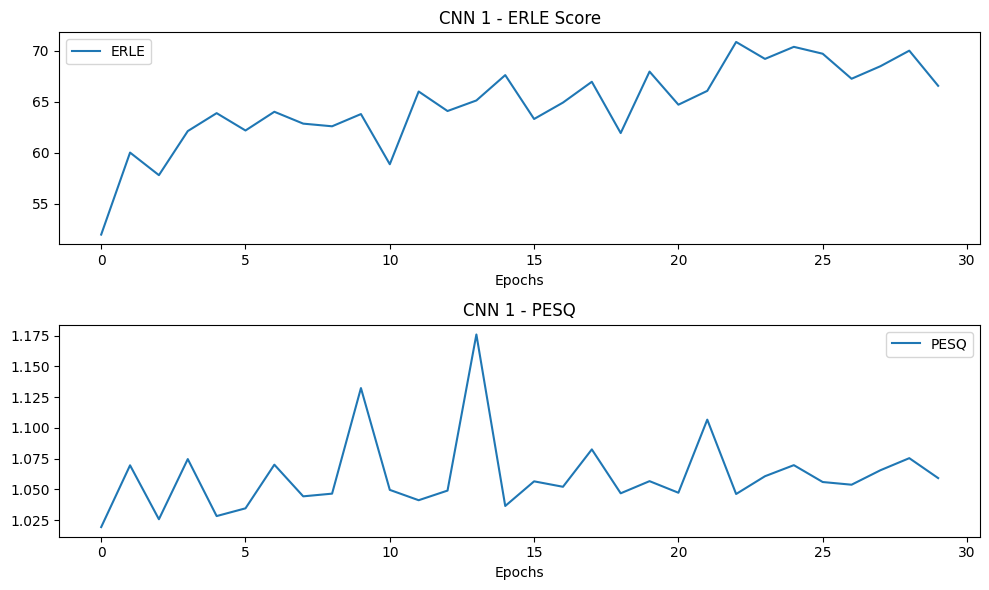

In [9]:
plt.figure(figsize=(10, 6)) 

plt.subplot(2,1,1)
plt.plot(erle_arr, label='ERLE')
plt.xlabel("Epochs")
plt.title("CNN 1 - ERLE Score")
plt.legend()

plt.subplot(2,1,2)
plt.plot(pesq_arr, label='PESQ')
plt.xlabel("Epochs")
plt.title("CNN 1 - PESQ")
plt.legend()

plt.tight_layout()
plt.show()

In [10]:
torch.save(model, "./models/CNN1.pth")

In [3]:
model = torch.load("./models/CNN1.pth")
model = model.to('cuda') 
model.eval()


EchoCancelCNN(
  (conv1): Conv2d(3, 8, kernel_size=(15, 15), stride=(1, 1), padding=(7, 7))
  (conv2): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv4): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv5): Conv2d(32, 1, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
)

In [4]:
# Sample i/p and o/p
(combined, near_mag, mixed_mag, far_mag1, far_mag2, phase) = functions.load_files("./data/mixed/1.wav", "./data/far_end/MGJC0_4.wav", "./data/far_end/MJRK0_3.wav", "./data/near_end/FAEM0_1.wav")
axis = 0
combined_input = torch.cat((far_mag1.unsqueeze(axis), far_mag2.unsqueeze(axis), mixed_mag.unsqueeze(axis)), axis=axis)
combined_input.shape

torch.Size([3, 257, 512])

In [5]:
outputs = model(combined_input.to('cuda')).reshape(257, 512).detach().cpu().numpy()
functions.to_wave(outputs, phase, filename="CNN2D_1", n_fft=512, hop_length=256, sr=16000, write=1)


array([ 1.0715500e-05, -4.8343804e-06,  1.0717732e-05, ...,
       -1.9793340e-06,  1.2500614e-05, -1.9784629e-06], dtype=float32)

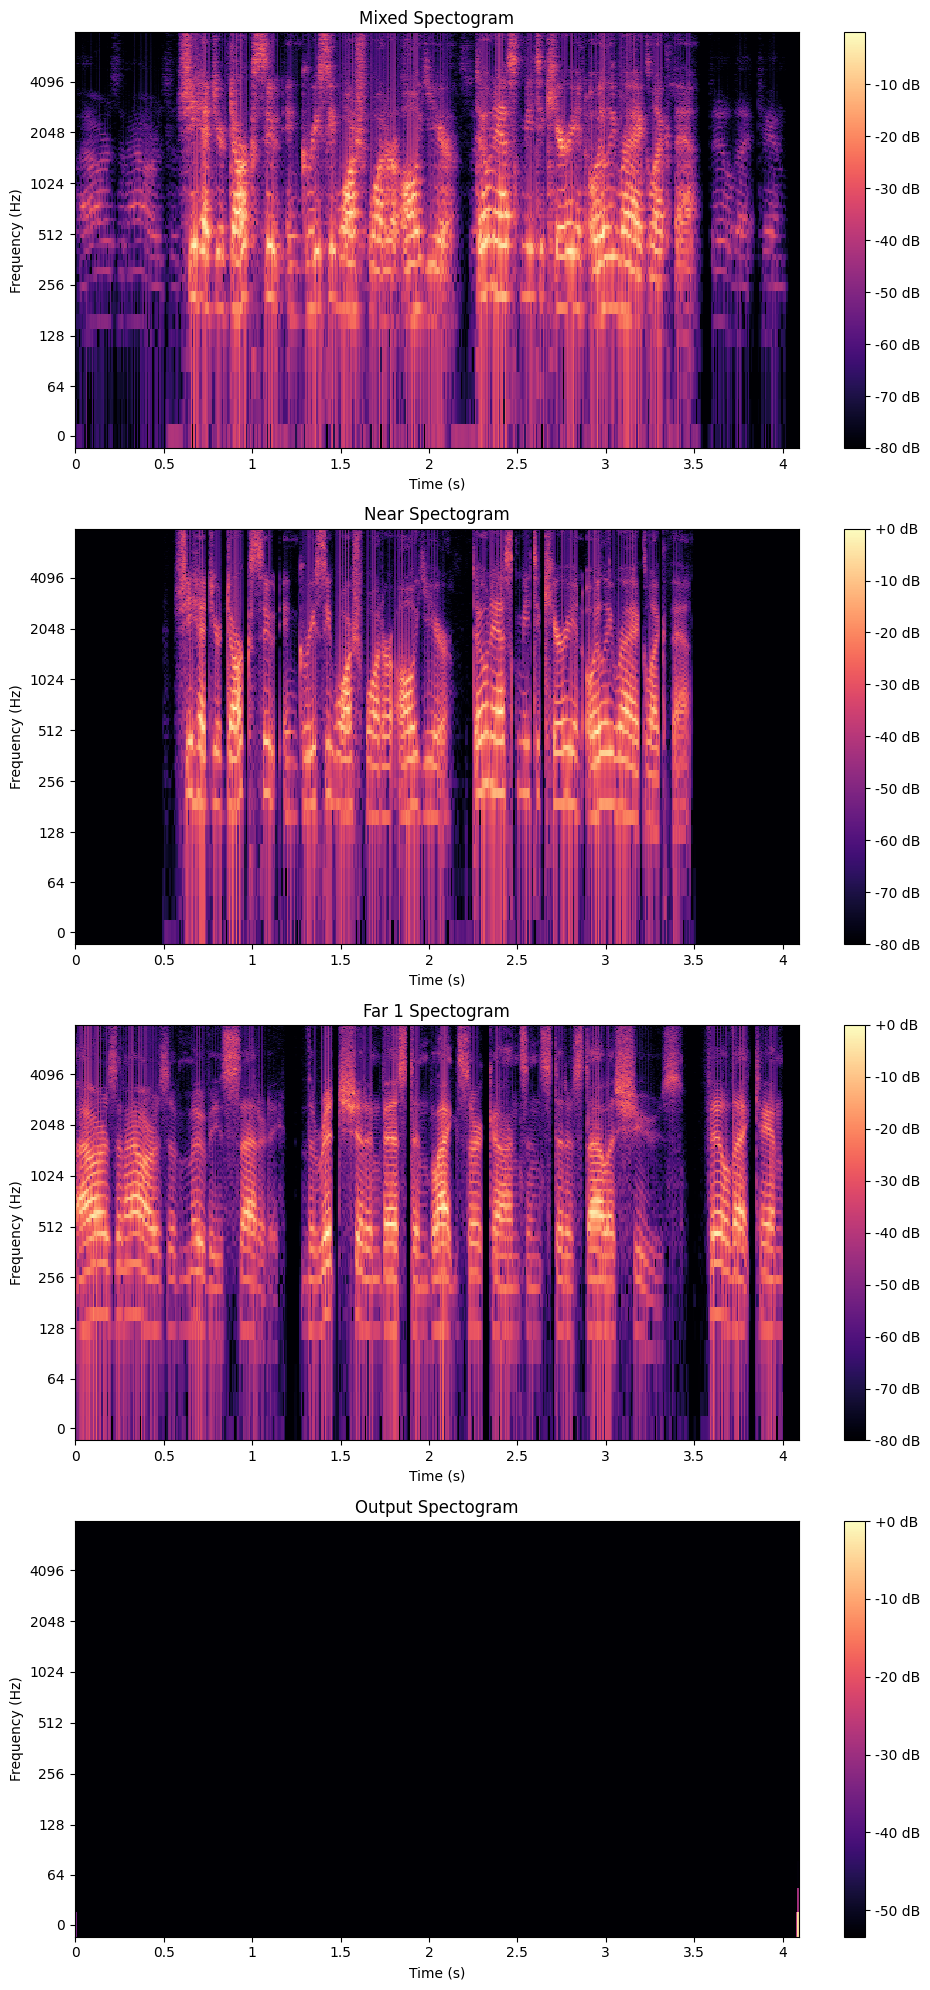

In [6]:
data = [mixed_mag, near_mag, far_mag1, outputs]
titles = ["Mixed Spectogram", "Near Spectogram", "Far 1 Spectogram", "Output Spectogram"]

functions.plot_spectograms(data, titles)

##### CNN 2

In [7]:
class EchoCancelCNN(nn.Module):
    def __init__(self):
        super(EchoCancelCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, kernel_size=5, padding=2) # 3 input channels are mixed, far1, far2 
        self.conv2 = nn.Conv2d(8, 16, kernel_size=5, padding=2)
        self.conv3 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(32, 1, kernel_size=3, padding=1)

    
    def forward(self, x):
        x = torch.relu(self.conv1(x))  #        [batch_size, 8, 257, 1021]
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = torch.relu(self.conv4(x))
        x = torch.sigmoid(self.conv5(x))
        
        return x

In [6]:
batch_size = 64
num_epochs = 30
n_fft = 512
hop_length = n_fft//2
learning_rate = 0.001
train_dataset = dataClass.WaveDataset(mixed, far1, far2, near, n_fft=n_fft, hop_length=hop_length)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
erle_arr=[]
pesq_arr=[]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
model = EchoCancelCNN().to(device)
summary(model, (3, 257, 512))

Layer (type:depth-idx)                   Output Shape              Param #
EchoCancelCNN                            [1, 257, 512]             --
├─Conv2d: 1-1                            [8, 257, 512]             608
├─Conv2d: 1-2                            [16, 257, 512]            3,216
├─Conv2d: 1-3                            [32, 257, 512]            4,640
├─Conv2d: 1-4                            [32, 257, 512]            9,248
├─Conv2d: 1-5                            [1, 257, 512]             289
Total params: 18,001
Trainable params: 18,001
Non-trainable params: 0
Total mult-adds (M): 256.52
Input size (MB): 1.58
Forward/backward pass size (MB): 93.69
Params size (MB): 0.07
Estimated Total Size (MB): 95.34

In [8]:
train_CNN(model, train_loader, num_epochs=num_epochs, learning_rate=learning_rate, erle_arr=erle_arr, pesq_arr=pesq_arr, device=device)

[Epoch   1/30] Train Loss: 0.0030, Duration: 2 minutes 58 seconds, ERLE Score: 30.52, PESQ Score: 1.02
[Epoch   2/30] Train Loss: 0.0080, Duration: 2 minutes 53 seconds, ERLE Score: 45.65, PESQ Score: 1.03
[Epoch   3/30] Train Loss: 0.0031, Duration: 2 minutes 52 seconds, ERLE Score: 41.76, PESQ Score: 1.04
[Epoch   4/30] Train Loss: 0.0081, Duration: 2 minutes 51 seconds, ERLE Score: 45.88, PESQ Score: 1.03
[Epoch   5/30] Train Loss: 0.0041, Duration: 2 minutes 51 seconds, ERLE Score: 42.98, PESQ Score: 1.06
[Epoch   6/30] Train Loss: 0.0042, Duration: 2 minutes 51 seconds, ERLE Score: 42.99, PESQ Score: 1.05
[Epoch   7/30] Train Loss: 0.0032, Duration: 2 minutes 51 seconds, ERLE Score: 41.93, PESQ Score: 1.02
[Epoch   8/30] Train Loss: 0.0033, Duration: 2 minutes 51 seconds, ERLE Score: 42.03, PESQ Score: 1.06
[Epoch   9/30] Train Loss: 0.0053, Duration: 2 minutes 51 seconds, ERLE Score: 44.16, PESQ Score: 1.05
[Epoch  10/30] Train Loss: 0.0029, Duration: 2 minutes 51 seconds, ERLE S

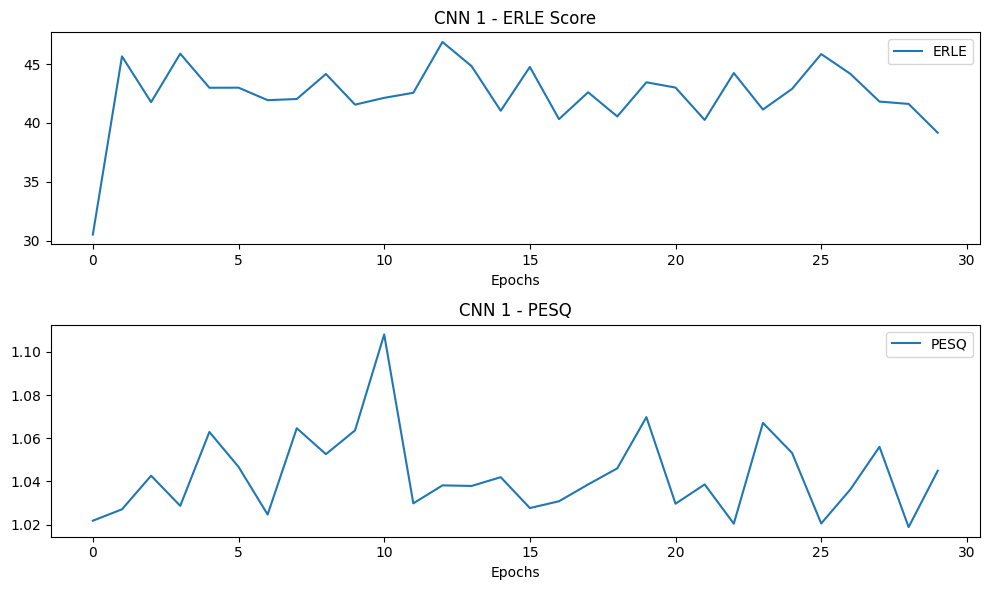

In [9]:
plt.figure(figsize=(10, 6)) 

plt.subplot(2,1,1)
plt.plot(erle_arr, label='ERLE')
plt.xlabel("Epochs")
plt.title("CNN 1 - ERLE Score")
plt.legend()

plt.subplot(2,1,2)
plt.plot(pesq_arr, label='PESQ')
plt.xlabel("Epochs")
plt.title("CNN 1 - PESQ")
plt.legend()

plt.tight_layout()
plt.show()

In [10]:
torch.save(model, "./models/CNN2.pth")

In [8]:
model = torch.load("./models/CNN2.pth")
model = model.to('cuda') 
model.eval()


EchoCancelCNN(
  (conv1): Conv2d(3, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(32, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [9]:
# Sample i/p and o/p
(combined, near_mag, mixed_mag, far_mag1, far_mag2, phase) = functions.load_files("./data/mixed/1.wav", "./data/far_end/MGJC0_4.wav", "./data/far_end/MJRK0_3.wav", "./data/near_end/FAEM0_1.wav")
axis = 0
combined_input = torch.cat((far_mag1.unsqueeze(axis), far_mag2.unsqueeze(axis), mixed_mag.unsqueeze(axis)), axis=axis)
combined_input.shape

torch.Size([3, 257, 512])

In [10]:
outputs = model(combined_input.to('cuda')).reshape(257, 512).detach().cpu().numpy()
functions.to_wave(outputs, phase, filename="CNN2D_2", n_fft=512, hop_length=256, sr=16000, write=1)

array([ 2.2049501e-04,  3.5079473e-05,  2.2054865e-04, ...,
       -3.7381098e-05,  1.5171389e-04, -3.7366401e-05], dtype=float32)

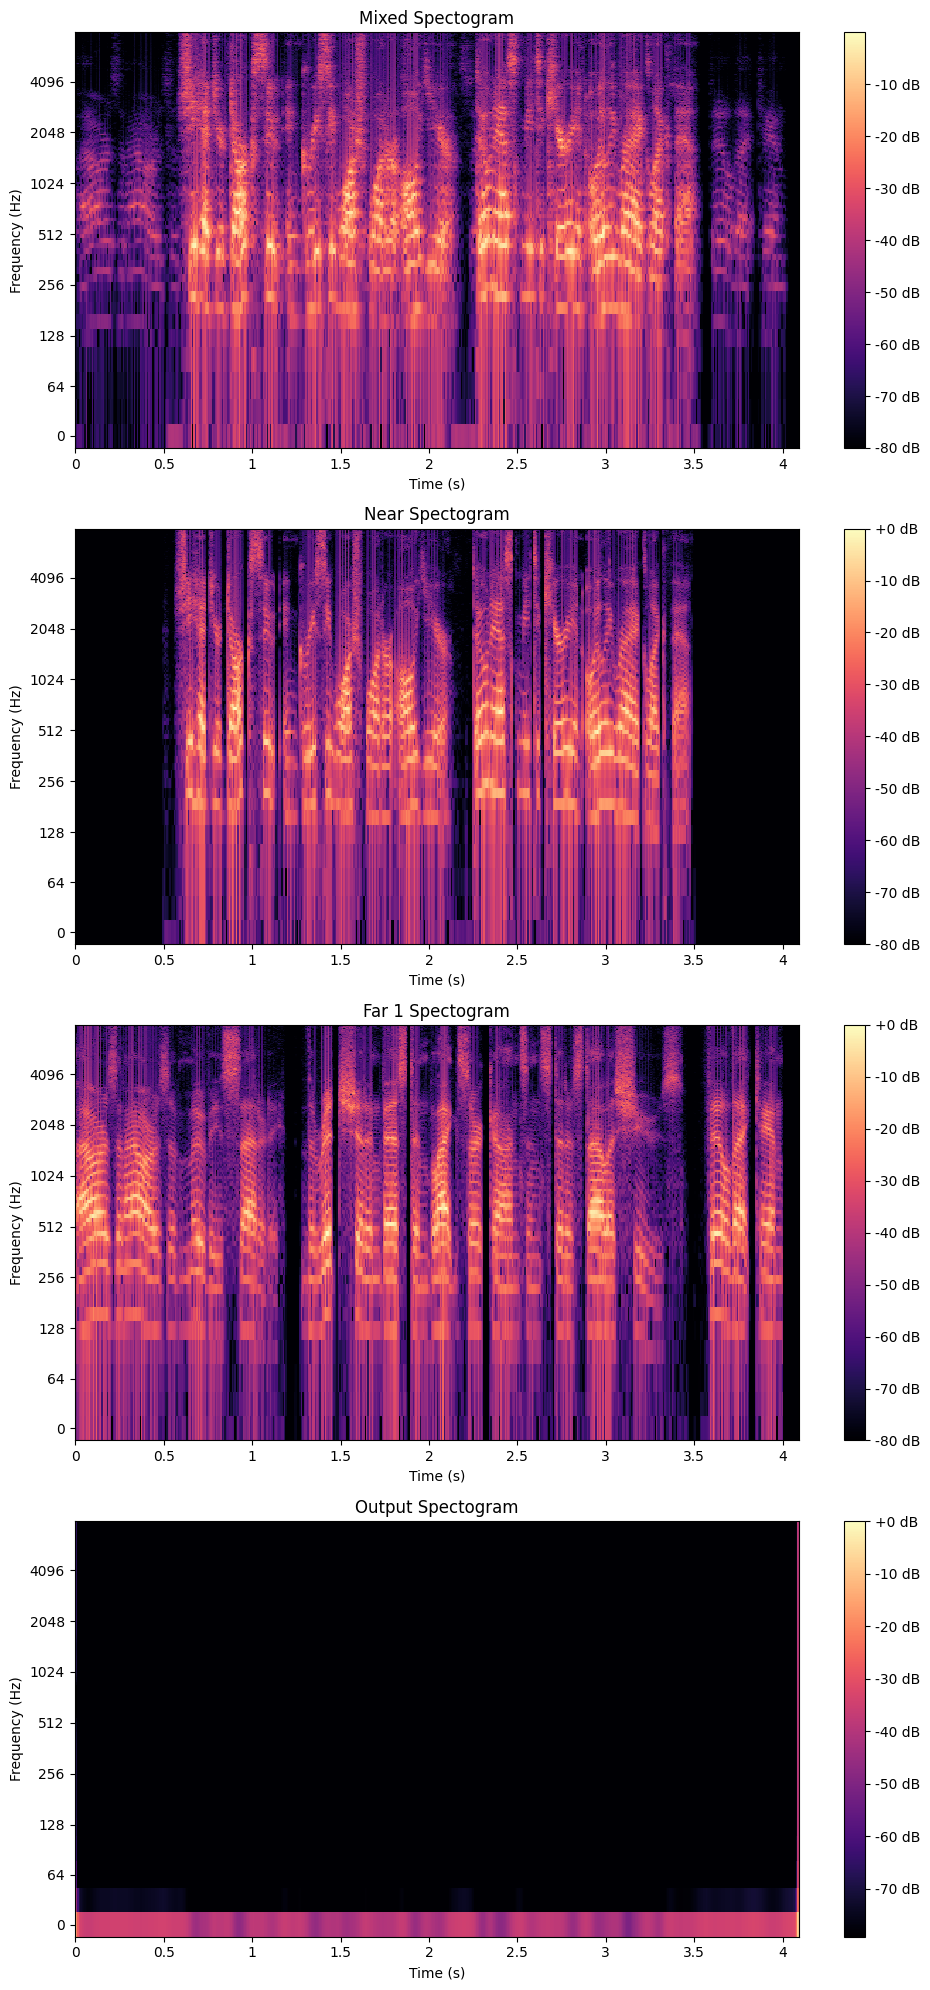

In [11]:
data = [mixed_mag, near_mag, far_mag1, outputs]
titles = ["Mixed Spectogram", "Near Spectogram", "Far 1 Spectogram", "Output Spectogram"]

functions.plot_spectograms(data, titles)

##### CNN 3

In [12]:
class EchoCancelCNN(nn.Module):
    def __init__(self):
        super(EchoCancelCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, kernel_size=11, padding=5) # 3 input channels are mixed, far1, far2 
        self.conv2 = nn.Conv2d(8, 16, kernel_size=5, padding=2)
        self.conv3 = nn.Conv2d(16, 32, kernel_size=5, padding=2)
        self.conv4 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(64, 1, kernel_size=3, padding=1)

    
    def forward(self, x):
        x = torch.relu(self.conv1(x))  #        [batch_size, 8, 257, 1021]
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = torch.relu(self.conv4(x))
        x = torch.sigmoid(self.conv5(x))
        
        return x

In [6]:
batch_size = 50
num_epochs = 30
n_fft = 512
hop_length = n_fft//2
learning_rate = 0.001
train_dataset = dataClass.WaveDataset(mixed, far1, far2, near, n_fft=n_fft, hop_length=hop_length)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
erle_arr=[]
pesq_arr=[]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
model = EchoCancelCNN().to(device)
summary(model, (3, 257, 512))

Layer (type:depth-idx)                   Output Shape              Param #
EchoCancelCNN                            [1, 257, 512]             --
├─Conv2d: 1-1                            [8, 257, 512]             2,912
├─Conv2d: 1-2                            [16, 257, 512]            3,216
├─Conv2d: 1-3                            [32, 257, 512]            12,832
├─Conv2d: 1-4                            [64, 257, 512]            18,496
├─Conv2d: 1-5                            [1, 257, 512]             577
Total params: 38,033
Trainable params: 38,033
Non-trainable params: 0
Total mult-adds (M): 854.88
Input size (MB): 1.58
Forward/backward pass size (MB): 127.37
Params size (MB): 0.15
Estimated Total Size (MB): 129.10

In [8]:
train_CNN(model, train_loader, num_epochs=num_epochs, learning_rate=learning_rate, erle_arr=erle_arr, pesq_arr=pesq_arr, device=device)

[Epoch   1/30] Train Loss: 0.0055, Duration: 4 minutes 46 seconds, ERLE Score: 57.31, PESQ Score: 1.04
[Epoch   2/30] Train Loss: 0.0039, Duration: 4 minutes 37 seconds, ERLE Score: 57.77, PESQ Score: 1.04
[Epoch   3/30] Train Loss: 0.0038, Duration: 4 minutes 36 seconds, ERLE Score: 57.74, PESQ Score: 1.04
[Epoch   4/30] Train Loss: 0.0055, Duration: 4 minutes 36 seconds, ERLE Score: 59.31, PESQ Score: 1.15
[Epoch   5/30] Train Loss: 0.0050, Duration: 4 minutes 36 seconds, ERLE Score: 58.96, PESQ Score: 1.05
[Epoch   6/30] Train Loss: 0.0045, Duration: 4 minutes 36 seconds, ERLE Score: 58.58, PESQ Score: 1.07
[Epoch   7/30] Train Loss: 0.0068, Duration: 4 minutes 36 seconds, ERLE Score: 60.30, PESQ Score: 1.06
[Epoch   8/30] Train Loss: 0.0048, Duration: 4 minutes 36 seconds, ERLE Score: 59.03, PESQ Score: 1.04
[Epoch   9/30] Train Loss: 0.0040, Duration: 4 minutes 36 seconds, ERLE Score: 58.54, PESQ Score: 1.16
[Epoch  10/30] Train Loss: 0.0047, Duration: 4 minutes 36 seconds, ERLE S

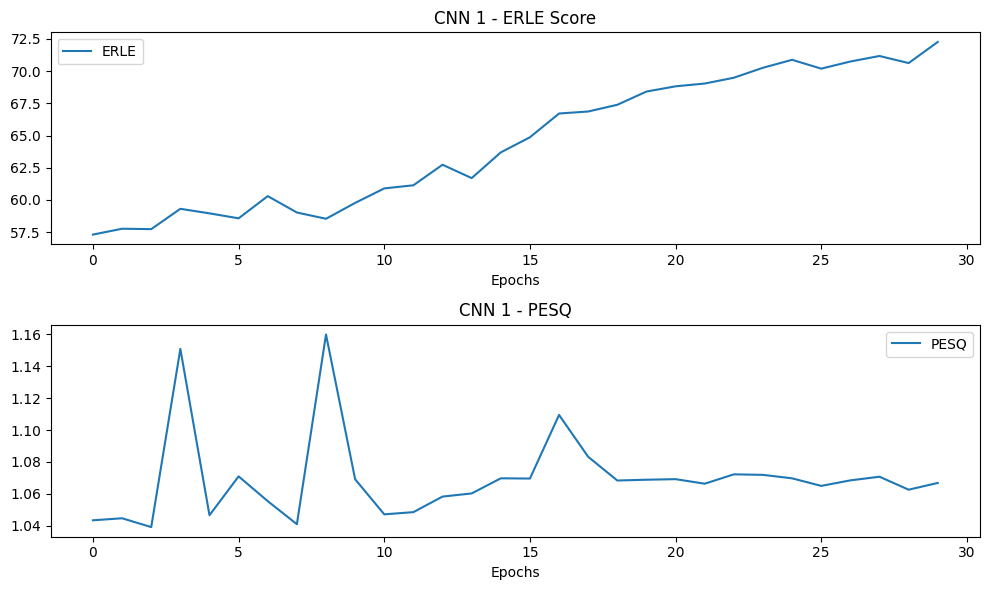

In [9]:
plt.figure(figsize=(10, 6)) 

plt.subplot(2,1,1)
plt.plot(erle_arr, label='ERLE')
plt.xlabel("Epochs")
plt.title("CNN 1 - ERLE Score")
plt.legend()

plt.subplot(2,1,2)
plt.plot(pesq_arr, label='PESQ')
plt.xlabel("Epochs")
plt.title("CNN 1 - PESQ")
plt.legend()

plt.tight_layout()
plt.show()

In [10]:
torch.save(model, "./models/CNN3.pth")

In [13]:
model = torch.load("./models/CNN3.pth")
model = model.to('cuda') 
model.eval()


EchoCancelCNN(
  (conv1): Conv2d(3, 8, kernel_size=(11, 11), stride=(1, 1), padding=(5, 5))
  (conv2): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [14]:
# Sample i/p and o/p
(combined, near_mag, mixed_mag, far_mag1, far_mag2, phase) = functions.load_files("./data/mixed/1.wav", "./data/far_end/MGJC0_4.wav", "./data/far_end/MJRK0_3.wav", "./data/near_end/FAEM0_1.wav")
axis = 0
combined_input = torch.cat((far_mag1.unsqueeze(axis), far_mag2.unsqueeze(axis), mixed_mag.unsqueeze(axis)), axis=axis)
combined_input.shape

torch.Size([3, 257, 512])

In [15]:
outputs = model(combined_input.to('cuda')).reshape(257, 512).detach().cpu().numpy()
functions.to_wave(outputs, phase, filename="CNN2D_3", n_fft=512, hop_length=256, sr=16000, write=1)

array([ 9.2635473e-06, -3.8726756e-07,  9.2650134e-06, ...,
        6.5635436e-07,  1.0811100e-05,  6.5613528e-07], dtype=float32)

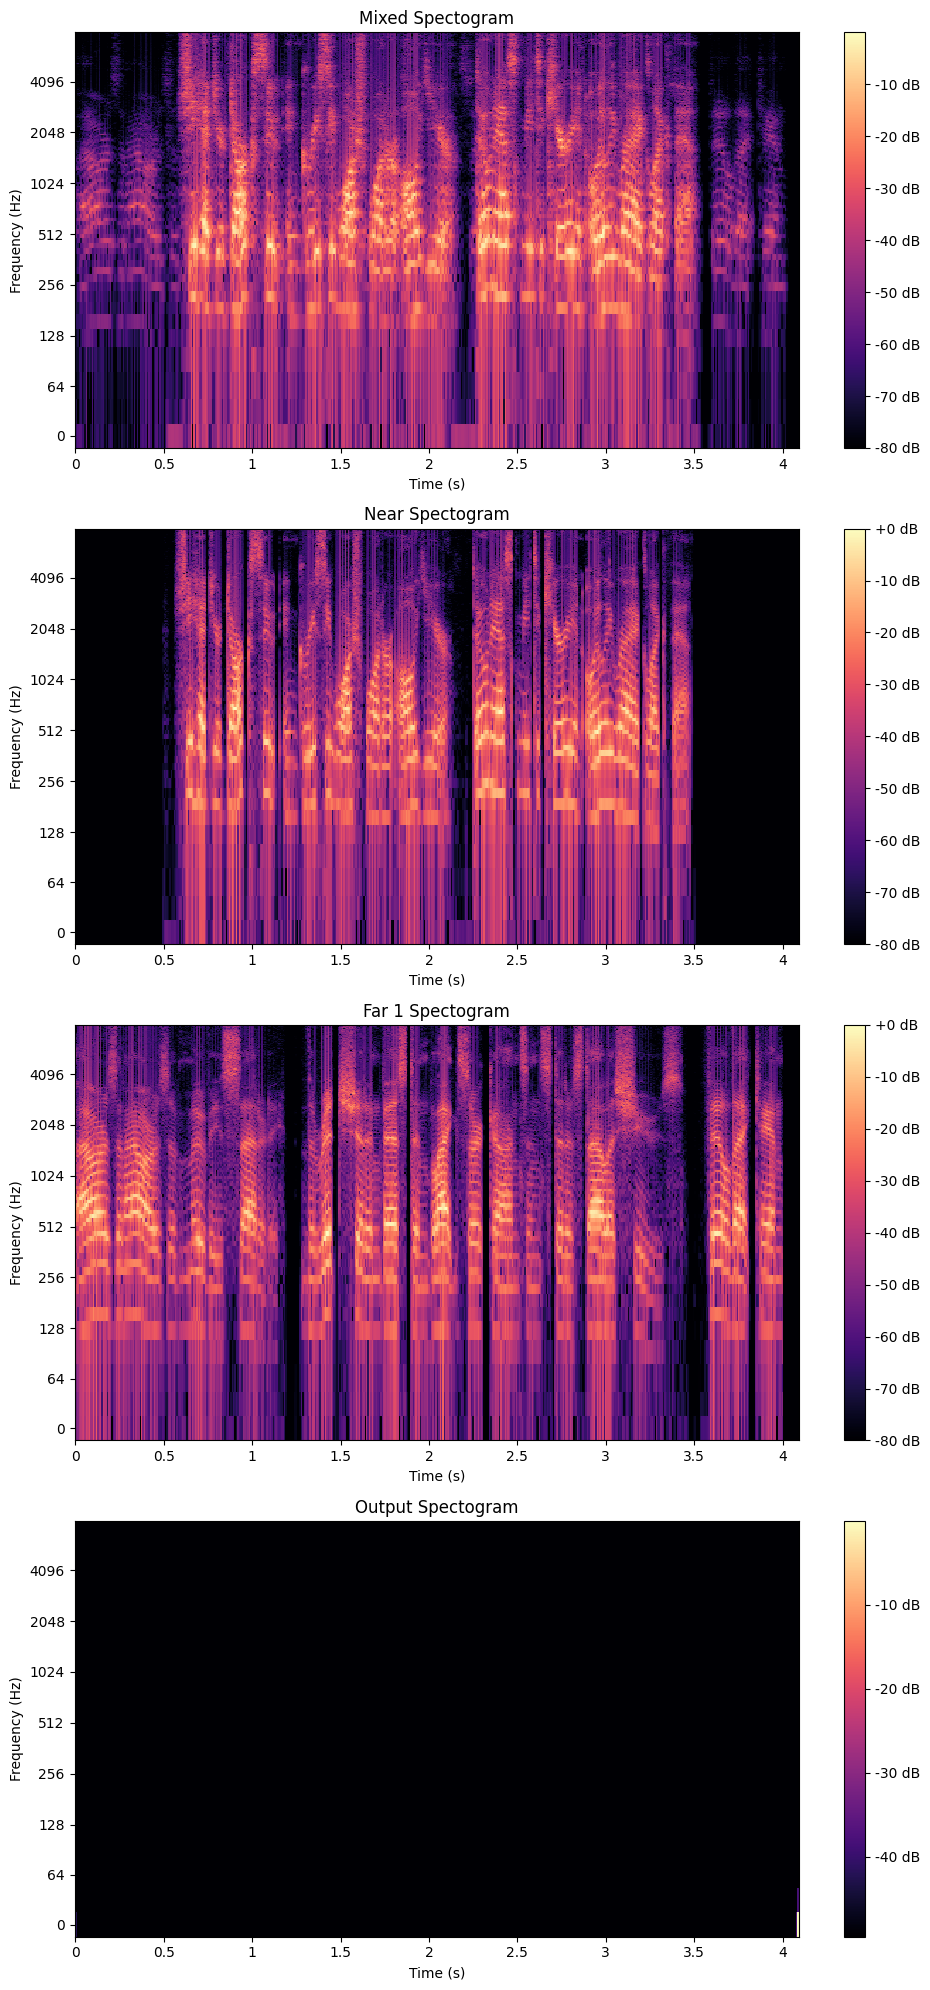

In [16]:
data = [mixed_mag, near_mag, far_mag1, outputs]
titles = ["Mixed Spectogram", "Near Spectogram", "Far 1 Spectogram", "Output Spectogram"]

functions.plot_spectograms(data, titles)

##### CNN 4

In [17]:
class EchoCancelCNN(nn.Module):
    def __init__(self):
        super(EchoCancelCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, kernel_size=7, padding=3) # 3 input channels are mixed, far1, far2 
        self.conv2 = nn.Conv2d(8, 16, kernel_size=5, padding=2)
        self.conv3 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(64, 1, kernel_size=3, padding=1)

    
    def forward(self, x):
        x = torch.relu(self.conv1(x))  #        [batch_size, 8, 257, 1021]
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = torch.relu(self.conv4(x))
        x = torch.sigmoid(self.conv5(x))
        
        return x

In [6]:
batch_size = 55
num_epochs = 30
n_fft = 512
hop_length = n_fft//2
learning_rate = 0.001
train_dataset = dataClass.WaveDataset(mixed, far1, far2, near, n_fft=n_fft, hop_length=hop_length)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
erle_arr=[]
pesq_arr=[]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
model = EchoCancelCNN().to(device)
summary(model, (3, 257, 512))

Layer (type:depth-idx)                   Output Shape              Param #
EchoCancelCNN                            [1, 257, 512]             --
├─Conv2d: 1-1                            [8, 257, 512]             1,184
├─Conv2d: 1-2                            [16, 257, 512]            3,216
├─Conv2d: 1-3                            [32, 257, 512]            4,640
├─Conv2d: 1-4                            [64, 257, 512]            18,496
├─Conv2d: 1-5                            [1, 257, 512]             577
Total params: 28,113
Trainable params: 28,113
Non-trainable params: 0
Total mult-adds (M): 713.59
Input size (MB): 1.58
Forward/backward pass size (MB): 127.37
Params size (MB): 0.11
Estimated Total Size (MB): 129.06

In [8]:
train_CNN(model, train_loader, num_epochs=num_epochs, learning_rate=learning_rate, erle_arr=erle_arr, pesq_arr=pesq_arr, device=device)

[Epoch   1/30] Train Loss: 0.0063, Duration: 3 minutes 24 seconds, ERLE Score: 45.98, PESQ Score: 1.04
[Epoch   2/30] Train Loss: 0.0060, Duration: 3 minutes 18 seconds, ERLE Score: 48.75, PESQ Score: 1.06
[Epoch   3/30] Train Loss: 0.0028, Duration: 3 minutes 17 seconds, ERLE Score: 45.48, PESQ Score: 1.04
[Epoch   4/30] Train Loss: 0.0046, Duration: 3 minutes 17 seconds, ERLE Score: 47.58, PESQ Score: 1.11
[Epoch   5/30] Train Loss: 0.0041, Duration: 3 minutes 18 seconds, ERLE Score: 47.10, PESQ Score: 1.04
[Epoch   6/30] Train Loss: 0.0049, Duration: 3 minutes 17 seconds, ERLE Score: 47.83, PESQ Score: 1.02
[Epoch   7/30] Train Loss: 0.0054, Duration: 3 minutes 18 seconds, ERLE Score: 48.21, PESQ Score: 1.02
[Epoch   8/30] Train Loss: 0.0062, Duration: 3 minutes 16 seconds, ERLE Score: 48.84, PESQ Score: 2.01
[Epoch   9/30] Train Loss: 0.0054, Duration: 3 minutes 16 seconds, ERLE Score: 48.13, PESQ Score: 1.03
[Epoch  10/30] Train Loss: 0.0036, Duration: 3 minutes 17 seconds, ERLE S

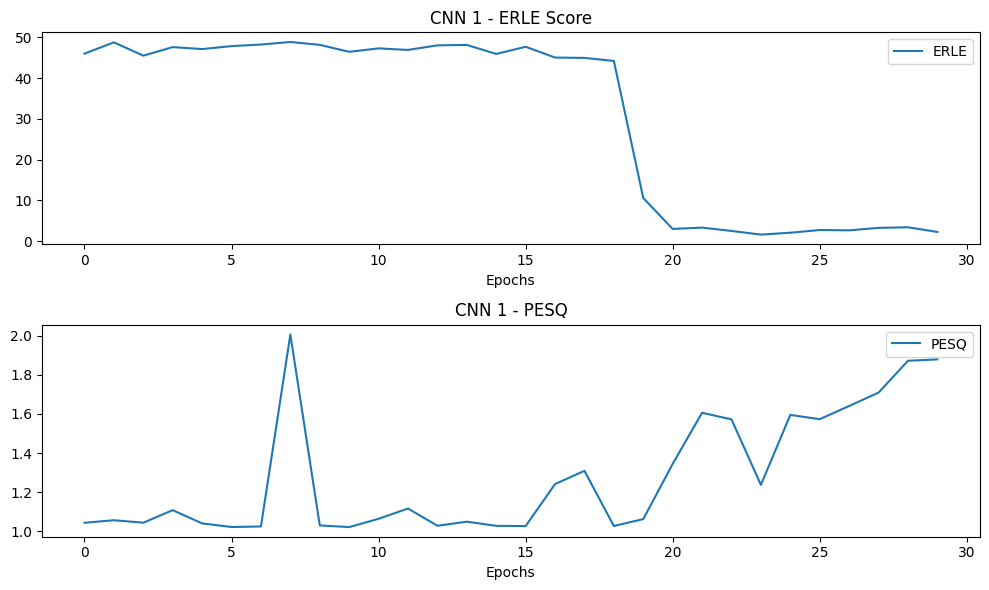

In [9]:
plt.figure(figsize=(10, 6)) 

plt.subplot(2,1,1)
plt.plot(erle_arr, label='ERLE')
plt.xlabel("Epochs")
plt.title("CNN 1 - ERLE Score")
plt.legend()

plt.subplot(2,1,2)
plt.plot(pesq_arr, label='PESQ')
plt.xlabel("Epochs")
plt.title("CNN 1 - PESQ")
plt.legend()

plt.tight_layout()
plt.show()

In [10]:
torch.save(model, "./models/CNN4.pth")

In [18]:
model = torch.load("./models/CNN4.pth")
model = model.to('cuda') 
model.eval()


EchoCancelCNN(
  (conv1): Conv2d(3, 8, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (conv2): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [19]:
# Sample i/p and o/p
(combined, near_mag, mixed_mag, far_mag1, far_mag2, phase) = functions.load_files("./data/mixed/1.wav", "./data/far_end/MGJC0_4.wav", "./data/far_end/MJRK0_3.wav", "./data/near_end/FAEM0_1.wav")
axis = 0
combined_input = torch.cat((far_mag1.unsqueeze(axis), far_mag2.unsqueeze(axis), mixed_mag.unsqueeze(axis)), axis=axis)
combined_input.shape

torch.Size([3, 257, 512])

In [20]:
outputs = model(combined_input.to('cuda')).reshape(257, 512).detach().cpu().numpy()
functions.to_wave(outputs, phase, filename="CNN2D_4", n_fft=512, hop_length=256, sr=16000, write=1)

array([ 8.4044179e-05, -2.5768564e-05,  8.2985469e-05, ...,
       -3.9412422e-05,  9.3079070e-05, -3.9396178e-05], dtype=float32)

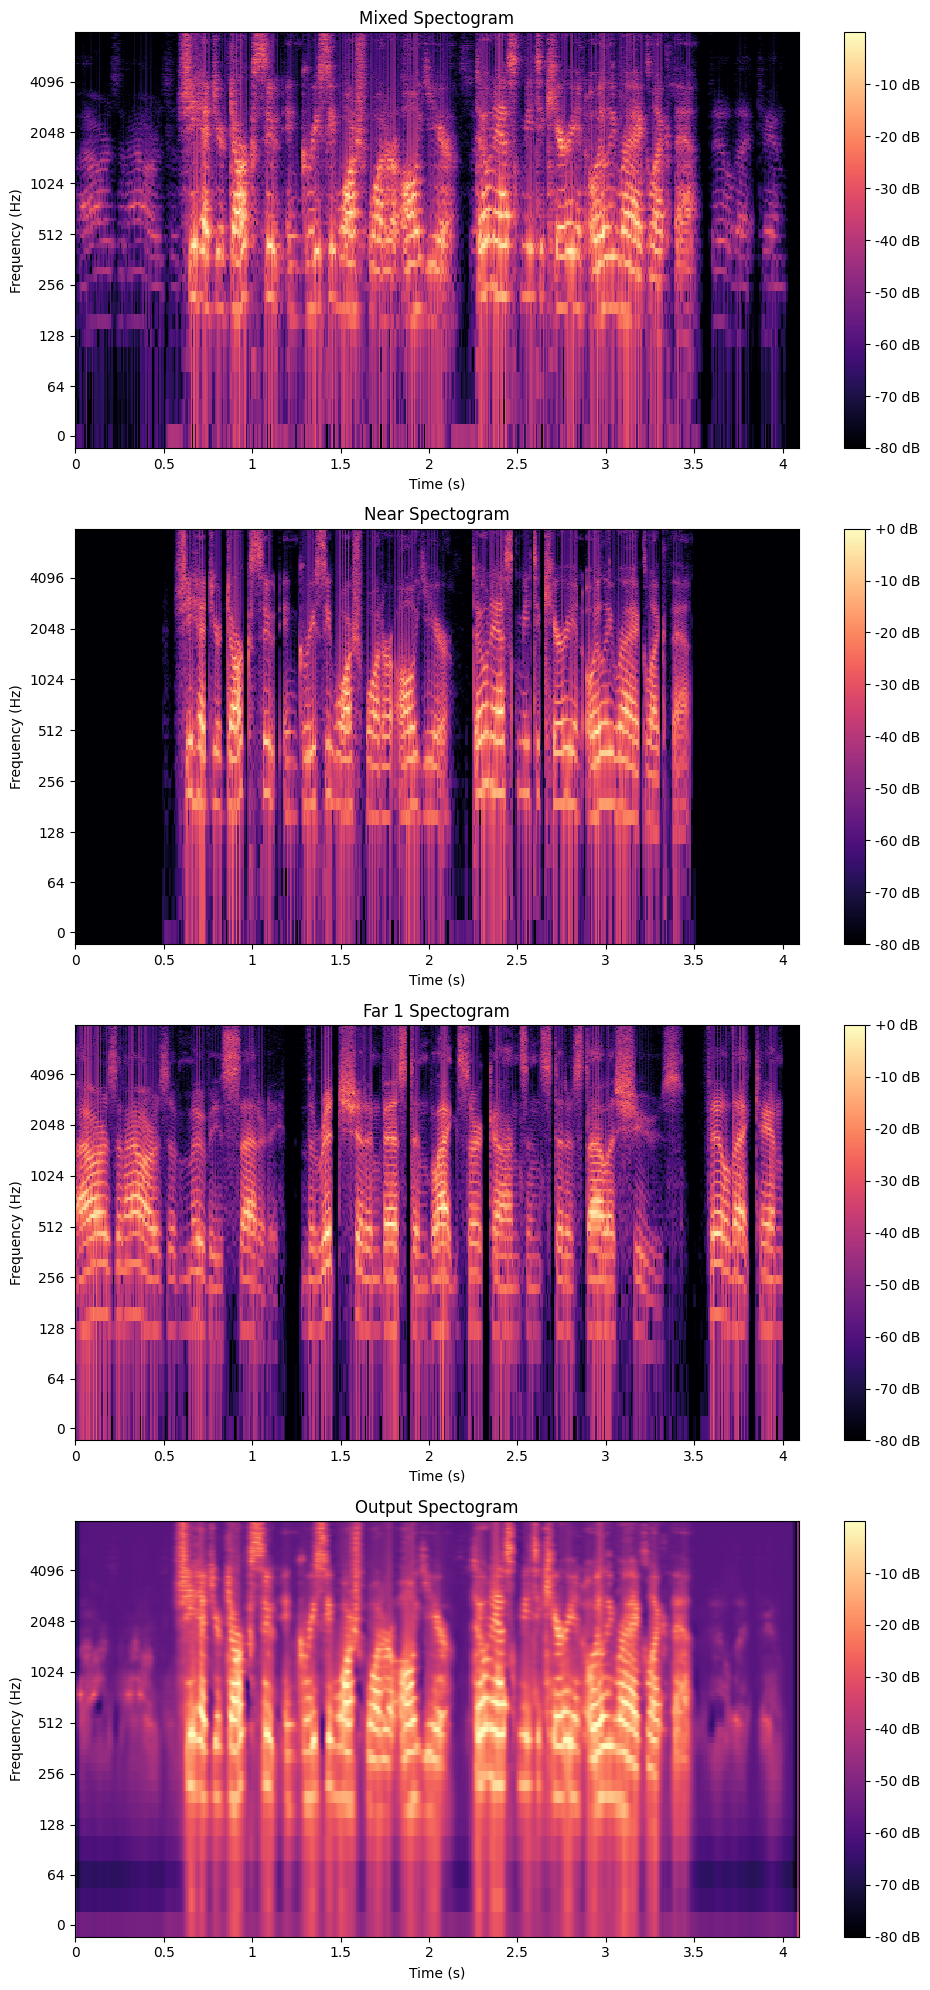

In [21]:
data = [mixed_mag, near_mag, far_mag1, outputs]
titles = ["Mixed Spectogram", "Near Spectogram", "Far 1 Spectogram", "Output Spectogram"]

functions.plot_spectograms(data, titles)

### LSTM

In [22]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        
        # x shape (batch, seq_len, input_dim)
        output, (hn, cn) = self.lstm(x, (h0, c0))  # Output shape (batch, seq_len, hidden_dim)
        output = self.fc(output) # Output shape (batch, seq_len, output_dim)
        return output

In [5]:
def train_LSTM(model, train_loader, num_epochs=10, learning_rate=0.001, device='cuda', erle_arr=[], pesq_arr=[], max_frames=512):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    model.train()  

    for epoch in range(num_epochs):
        start_time = time.time()
        for mixed, far1, far2, near, near_phase in train_loader:
            optimizer.zero_grad()
            outputs = model(mixed.transpose(1,2)) # LSTM (batch, sequence, features) 
            outputs = outputs.transpose(1,2)
            loss = criterion(outputs, near)
            loss.backward()
            optimizer.step()

        near_phase = near_phase.cpu().numpy()
        near = near.cpu().numpy()
        outputs = outputs.detach().cpu().squeeze(1).numpy()
        erle_score = functions.compute_erle(near, outputs)
        near_wave = functions.to_wave(near[0], near_phase[0], write=0, filename="near")
        output_wave = functions.to_wave(outputs[0], near_phase[0], write=0, filename="output")
        pesq_score = pesq(16000, near_wave, output_wave)
        erle_arr.append(erle_score)
        pesq_arr.append(pesq_score)
        duration = functions.timeit(start_time)
        print(f"[Epoch {epoch+1:3d}/{num_epochs:2d}] Train Loss: {loss.item():.4f}, Duration: {duration}, ERLE Score: {erle_score:.2f}, PESQ Score: {pesq_score:.2f}")
        

##### LSTM 1

In [27]:
# Parameters
batch_size = 128
num_epochs = 30
n_fft = 512
hop_length = n_fft//2
learning_rate = 0.001
train_dataset = dataClass.WaveDataset(mixed, far1, far2, near, n_fft=n_fft, hop_length=hop_length)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
erle_arr=[]
pesq_arr=[]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# LSTM params
num_layers = 2
hidden_dim = 256
input_dim = 257
output_dim = 257

In [7]:
lstm = LSTM(input_dim, hidden_dim, num_layers, output_dim).to(device)
summary(lstm, (1, 512, 257))

Layer (type:depth-idx)                   Output Shape              Param #
LSTM                                     [1, 512, 257]             --
├─LSTM: 1-1                              [1, 512, 256]             1,053,696
├─Linear: 1-2                            [1, 512, 257]             66,049
Total params: 1,119,745
Trainable params: 1,119,745
Non-trainable params: 0
Total mult-adds (M): 539.56
Input size (MB): 0.53
Forward/backward pass size (MB): 2.10
Params size (MB): 4.48
Estimated Total Size (MB): 7.11

In [8]:
train_LSTM(lstm, train_loader, num_epochs=num_epochs, learning_rate=learning_rate, erle_arr=erle_arr, pesq_arr=pesq_arr, device=device)

[Epoch   1/30] Train Loss: 0.0036, Duration: 22 seconds, ERLE Score: 6.87, PESQ Score: 1.03
[Epoch   2/30] Train Loss: 0.0035, Duration: 20 seconds, ERLE Score: 6.03, PESQ Score: 1.03
[Epoch   3/30] Train Loss: 0.0030, Duration: 19 seconds, ERLE Score: 5.07, PESQ Score: 1.04
[Epoch   4/30] Train Loss: 0.0027, Duration: 19 seconds, ERLE Score: 4.29, PESQ Score: 1.08
[Epoch   5/30] Train Loss: 0.0027, Duration: 19 seconds, ERLE Score: 3.59, PESQ Score: 1.11
[Epoch   6/30] Train Loss: 0.0024, Duration: 19 seconds, ERLE Score: 3.53, PESQ Score: 1.09
[Epoch   7/30] Train Loss: 0.0027, Duration: 19 seconds, ERLE Score: 3.45, PESQ Score: 1.16
[Epoch   8/30] Train Loss: 0.0021, Duration: 19 seconds, ERLE Score: 3.09, PESQ Score: 1.05
[Epoch   9/30] Train Loss: 0.0024, Duration: 19 seconds, ERLE Score: 4.09, PESQ Score: 1.10
[Epoch  10/30] Train Loss: 0.0028, Duration: 19 seconds, ERLE Score: 3.64, PESQ Score: 1.17
[Epoch  11/30] Train Loss: 0.0025, Duration: 19 seconds, ERLE Score: 2.82, PESQ 

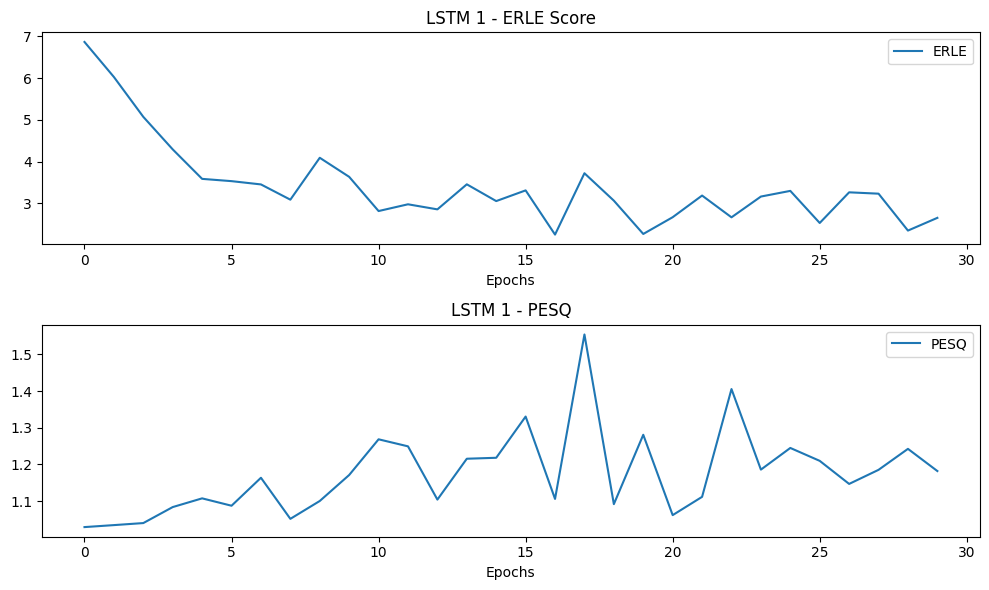

In [9]:
plt.figure(figsize=(10, 6)) 

plt.subplot(2,1,1)
plt.plot(erle_arr, label='ERLE')
plt.xlabel("Epochs")
plt.title("LSTM 1 - ERLE Score")
plt.legend()

plt.subplot(2,1,2)
plt.plot(pesq_arr, label='PESQ')
plt.xlabel("Epochs")
plt.title("LSTM 1 - PESQ")
plt.legend()

plt.tight_layout()
plt.show()

In [10]:
torch.save(lstm, "./models/LSTM1.pth")

In [23]:
model = torch.load("./models/LSTM1.pth")
model = model.to('cuda') 
model.eval()


LSTM(
  (lstm): LSTM(257, 256, num_layers=2, batch_first=True)
  (fc): Linear(in_features=256, out_features=257, bias=True)
)

In [24]:
# Sample i/p and o/p
(combined, near_mag, mixed_mag, far_mag1, far_mag2, phase) = functions.load_files("./data/mixed/1.wav", "./data/far_end/MGJC0_4.wav", "./data/far_end/MJRK0_3.wav", "./data/near_end/FAEM0_1.wav")
combined_input = mixed_mag.transpose(0,1).unsqueeze(0)
combined_input.shape

torch.Size([1, 512, 257])

In [25]:
outputs = model(combined_input.to('cuda')).transpose(1, 2).squeeze(0).detach().cpu().numpy()
functions.to_wave(outputs, phase, filename="LSTM_1", n_fft=512, hop_length=256, sr=16000, write=1)

array([ 7.1744178e-04,  1.7937832e-04,  2.6045140e-04, ...,
       -3.7951743e-06,  5.6803859e-05, -4.6359859e-05], dtype=float32)

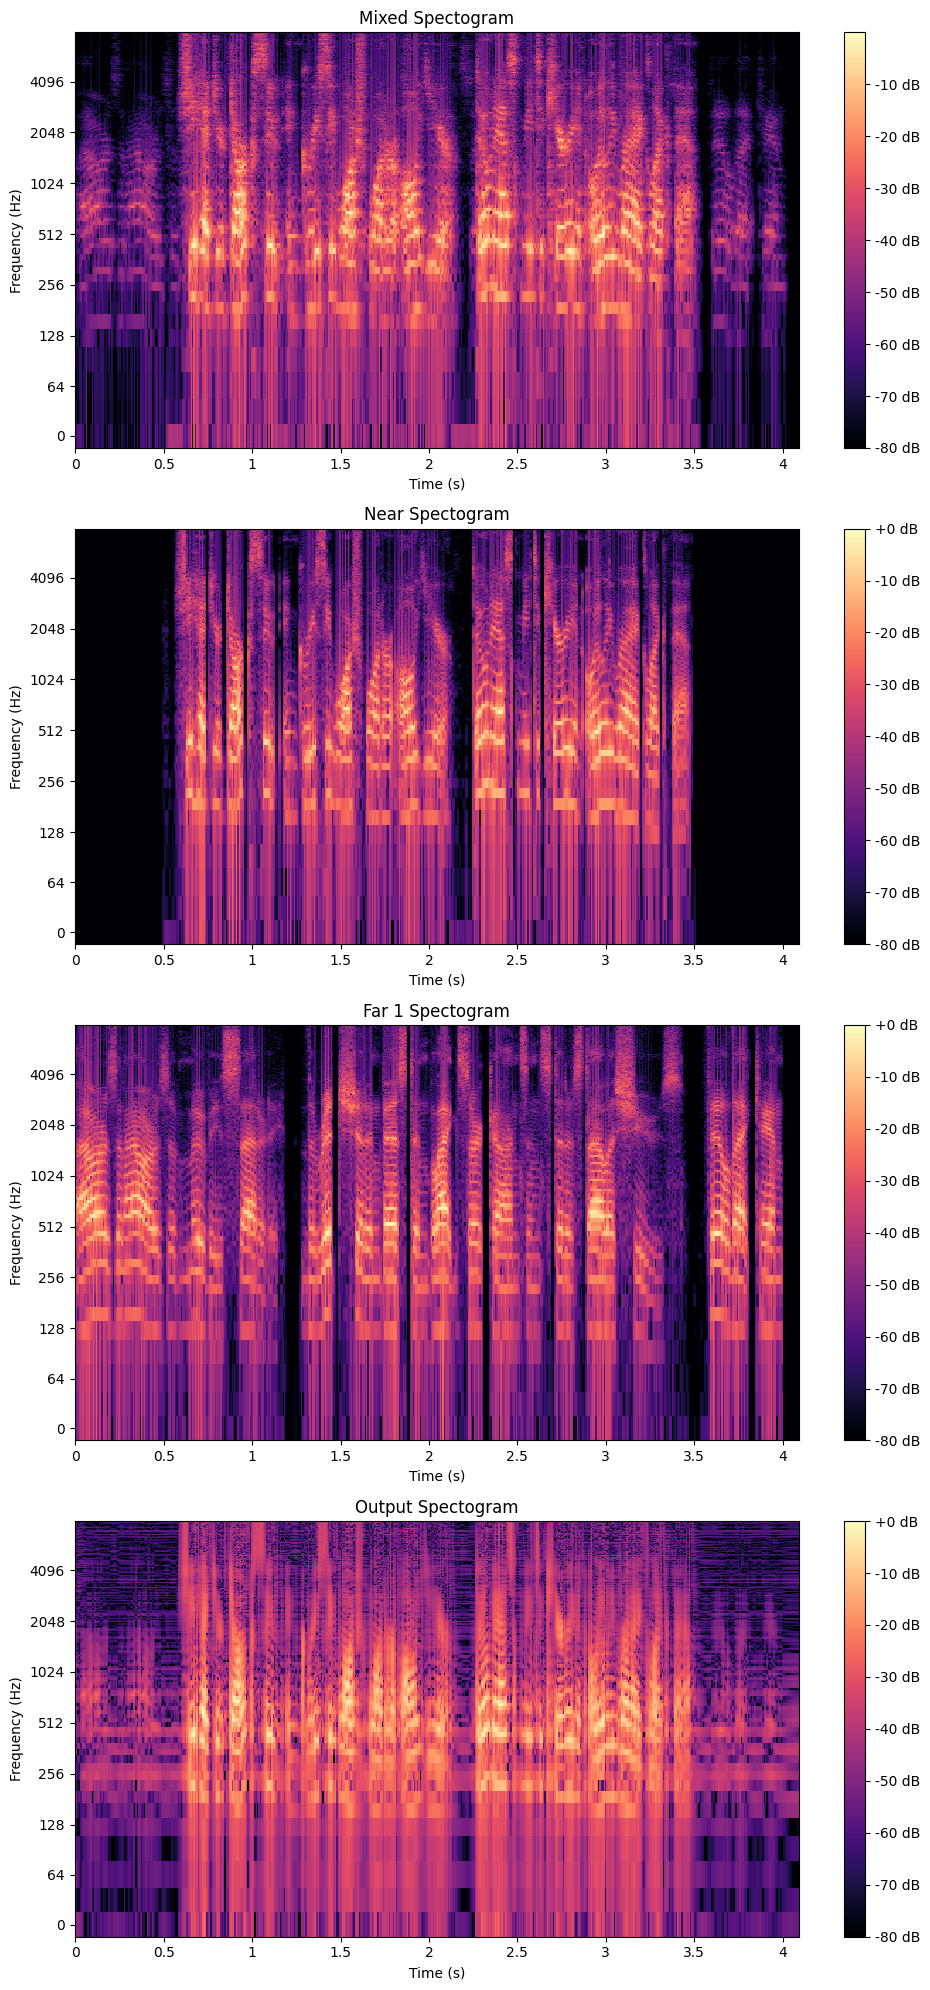

In [26]:
data = [mixed_mag, near_mag, far_mag1, outputs]
titles = ["Mixed Spectogram", "Near Spectogram", "Far 1 Spectogram", "Output Spectogram"]

functions.plot_spectograms(data, titles)

##### LSTM 2

In [11]:
# Parameters
batch_size = 128
num_epochs = 30
n_fft = 512
hop_length = n_fft//2
learning_rate = 0.001
train_dataset = dataClass.WaveDataset(mixed, far1, far2, near, n_fft=n_fft, hop_length=hop_length)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
erle_arr=[]
pesq_arr=[]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# LSTM params
num_layers = 3
hidden_dim = 256
input_dim = 257
output_dim = 257

In [12]:
lstm = LSTM(input_dim, hidden_dim, num_layers, output_dim).to(device)
summary(lstm, (1, 512, 257))

Layer (type:depth-idx)                   Output Shape              Param #
LSTM                                     [1, 512, 257]             --
├─LSTM: 1-1                              [1, 512, 256]             1,580,032
├─Linear: 1-2                            [1, 512, 257]             66,049
Total params: 1,646,081
Trainable params: 1,646,081
Non-trainable params: 0
Total mult-adds (M): 809.04
Input size (MB): 0.53
Forward/backward pass size (MB): 2.10
Params size (MB): 6.58
Estimated Total Size (MB): 9.21

In [13]:
train_LSTM(lstm, train_loader, num_epochs=num_epochs, learning_rate=learning_rate, erle_arr=erle_arr, pesq_arr=pesq_arr, device=device)

[Epoch   1/30] Train Loss: 0.0047, Duration: 20 seconds, ERLE Score: 7.33, PESQ Score: 1.02
[Epoch   2/30] Train Loss: 0.0031, Duration: 20 seconds, ERLE Score: 5.39, PESQ Score: 1.04
[Epoch   3/30] Train Loss: 0.0033, Duration: 20 seconds, ERLE Score: 5.71, PESQ Score: 1.05
[Epoch   4/30] Train Loss: 0.0029, Duration: 20 seconds, ERLE Score: 4.63, PESQ Score: 1.06
[Epoch   5/30] Train Loss: 0.0028, Duration: 20 seconds, ERLE Score: 4.46, PESQ Score: 1.06
[Epoch   6/30] Train Loss: 0.0025, Duration: 20 seconds, ERLE Score: 3.59, PESQ Score: 1.09
[Epoch   7/30] Train Loss: 0.0027, Duration: 20 seconds, ERLE Score: 3.56, PESQ Score: 1.09
[Epoch   8/30] Train Loss: 0.0027, Duration: 20 seconds, ERLE Score: 3.55, PESQ Score: 1.12
[Epoch   9/30] Train Loss: 0.0021, Duration: 20 seconds, ERLE Score: 2.90, PESQ Score: 1.10
[Epoch  10/30] Train Loss: 0.0025, Duration: 20 seconds, ERLE Score: 4.23, PESQ Score: 1.13
[Epoch  11/30] Train Loss: 0.0029, Duration: 20 seconds, ERLE Score: 3.12, PESQ 

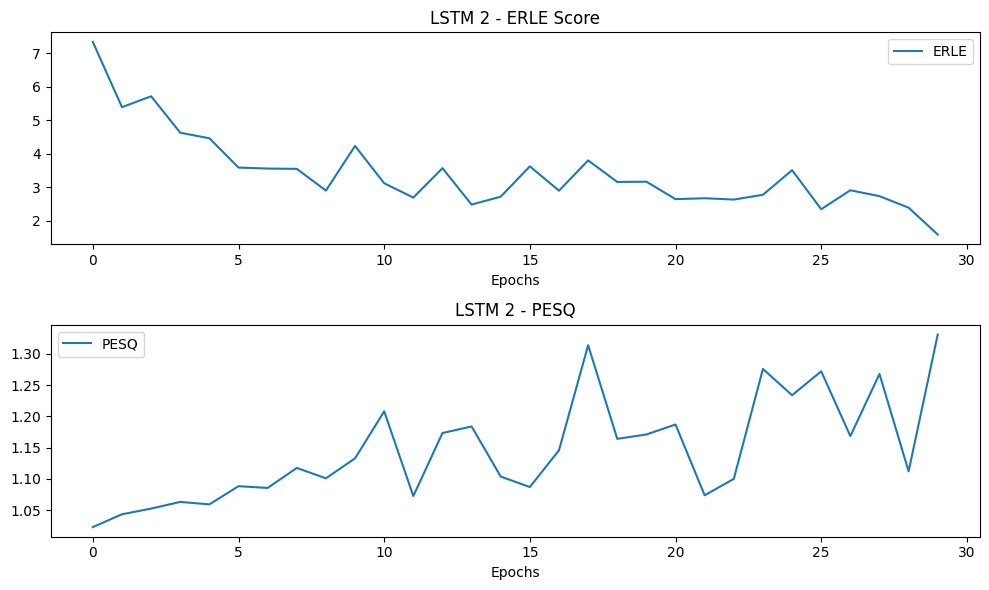

In [14]:
plt.figure(figsize=(10, 6)) 

plt.subplot(2,1,1)
plt.plot(erle_arr, label='ERLE')
plt.xlabel("Epochs")
plt.title("LSTM 2 - ERLE Score")
plt.legend()

plt.subplot(2,1,2)
plt.plot(pesq_arr, label='PESQ')
plt.xlabel("Epochs")
plt.title("LSTM 2 - PESQ")
plt.legend()

plt.tight_layout()
plt.show()

In [15]:
torch.save(lstm, "./models/LSTM2.pth")

In [27]:
lstm = torch.load("./models/LSTM2.pth")
lstm = lstm.to('cuda') 
lstm.eval()


LSTM(
  (lstm): LSTM(257, 256, num_layers=3, batch_first=True)
  (fc): Linear(in_features=256, out_features=257, bias=True)
)

In [28]:
# Sample i/p and o/p
(combined, near_mag, mixed_mag, far_mag1, far_mag2, phase) = functions.load_files("./data/mixed/1.wav", "./data/far_end/MGJC0_4.wav", "./data/far_end/MJRK0_3.wav", "./data/near_end/FAEM0_1.wav")
combined_input = mixed_mag.transpose(0,1).unsqueeze(0)
combined_input.shape

torch.Size([1, 512, 257])

In [29]:
outputs = model(combined_input.to('cuda')).transpose(1, 2).squeeze(0).detach().cpu().numpy()
functions.to_wave(outputs, phase, filename="LSTM_2", n_fft=512, hop_length=256, sr=16000, write=1)

array([ 7.1744178e-04,  1.7937832e-04,  2.6045140e-04, ...,
       -3.7951743e-06,  5.6803859e-05, -4.6359859e-05], dtype=float32)

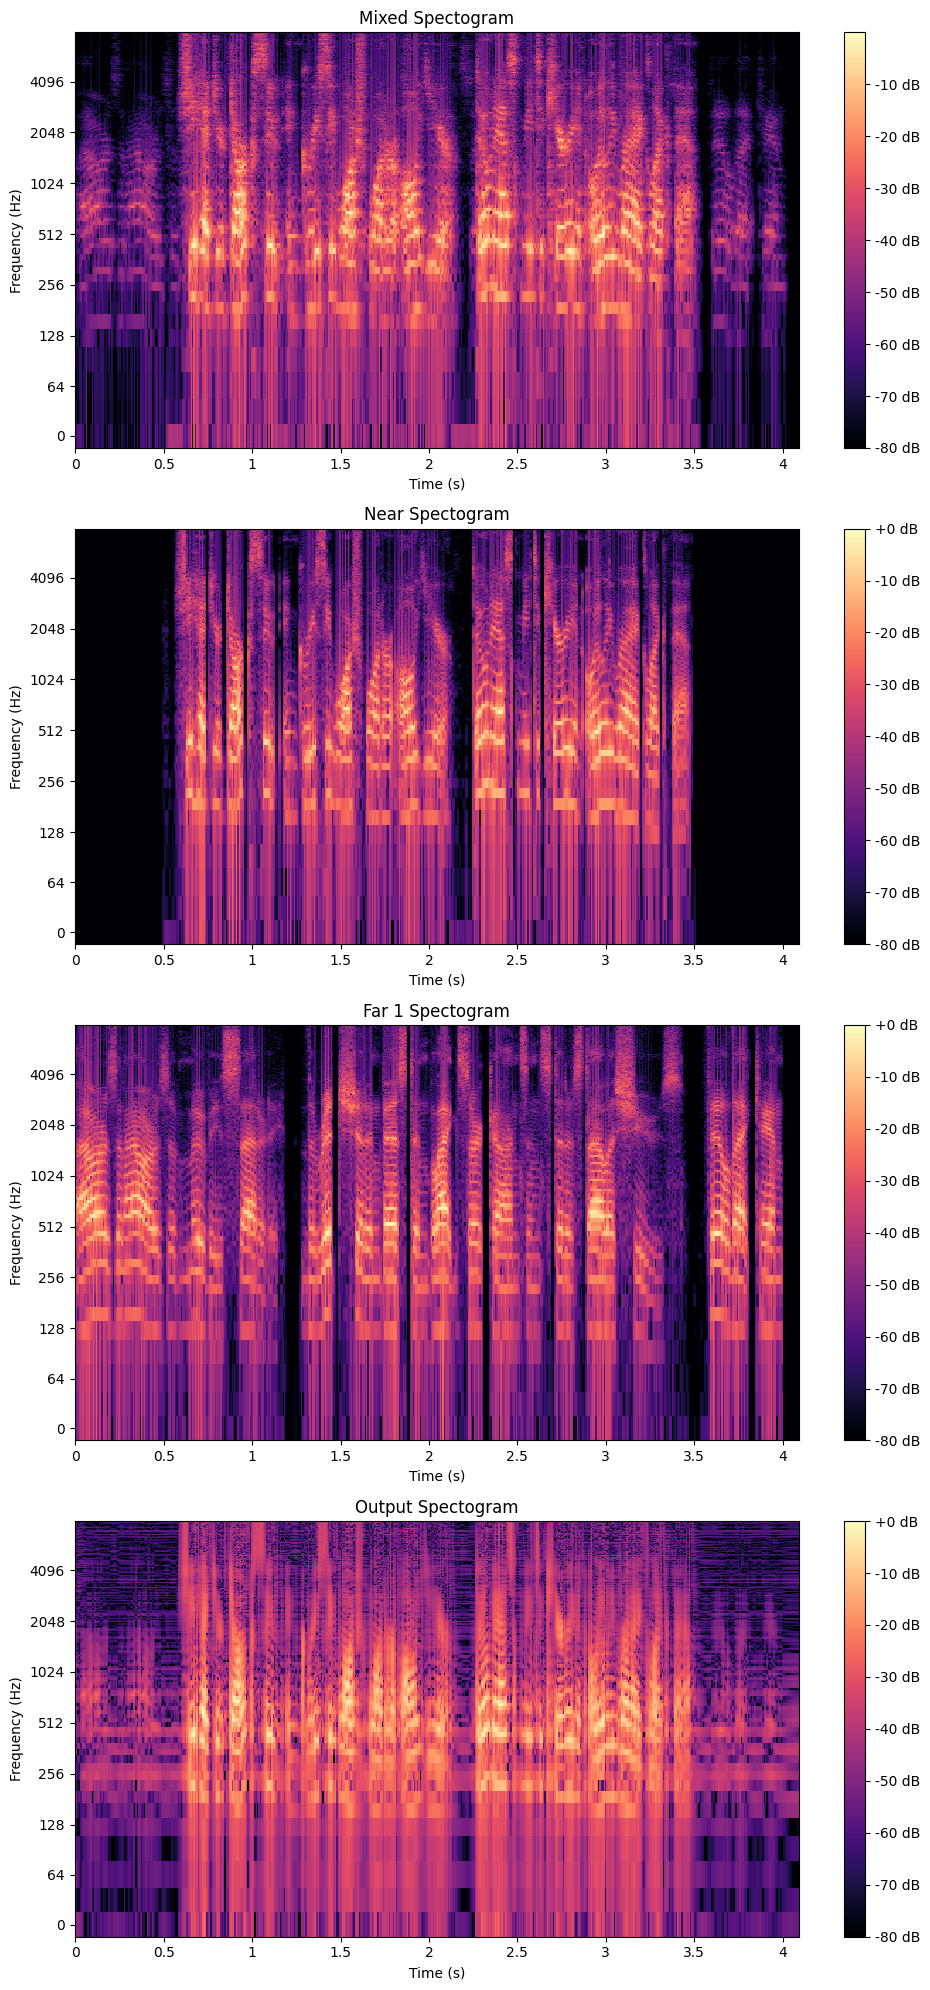

In [30]:
data = [mixed_mag, near_mag, far_mag1, outputs]
titles = ["Mixed Spectogram", "Near Spectogram", "Far 1 Spectogram", "Output Spectogram"]

functions.plot_spectograms(data, titles)

##### LSTM 3

In [16]:
# Parameters
batch_size = 128
num_epochs = 30
learning_rate = 0.001
n_fft = 512
hop_length = n_fft//2
learning_rate = 0.001
train_dataset = dataClass.WaveDataset(mixed, far1, far2, near, n_fft=n_fft, hop_length=hop_length)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
erle_arr=[]
pesq_arr=[]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# LSTM params
num_layers = 3
hidden_dim = 1024
input_dim = 257
output_dim = 257

In [17]:
lstm = LSTM(input_dim, hidden_dim, num_layers, output_dim).to(device)
summary(lstm, (1, 512, 257))

Layer (type:depth-idx)                   Output Shape              Param #
LSTM                                     [1, 512, 257]             --
├─LSTM: 1-1                              [1, 512, 1024]            22,048,768
├─Linear: 1-2                            [1, 512, 257]             263,425
Total params: 22,312,193
Trainable params: 22,312,193
Non-trainable params: 0
Total mult-adds (G): 11.29
Input size (MB): 0.53
Forward/backward pass size (MB): 5.25
Params size (MB): 89.25
Estimated Total Size (MB): 95.02

In [18]:
train_LSTM(lstm, train_loader, num_epochs=num_epochs, learning_rate=learning_rate, erle_arr=erle_arr, pesq_arr=pesq_arr, device=device)

[Epoch   1/30] Train Loss: 0.0035, Duration: 4 minutes 5 seconds, ERLE Score: 4.74, PESQ Score: 1.04
[Epoch   2/30] Train Loss: 0.0030, Duration: 4 minutes 4 seconds, ERLE Score: 4.72, PESQ Score: 1.06
[Epoch   3/30] Train Loss: 0.0033, Duration: 4 minutes 4 seconds, ERLE Score: 4.25, PESQ Score: 1.02
[Epoch   4/30] Train Loss: 0.0026, Duration: 4 minutes 4 seconds, ERLE Score: 3.66, PESQ Score: 1.12
[Epoch   5/30] Train Loss: 0.0025, Duration: 4 minutes 4 seconds, ERLE Score: 3.06, PESQ Score: 1.15
[Epoch   6/30] Train Loss: 0.0028, Duration: 4 minutes 4 seconds, ERLE Score: 2.90, PESQ Score: 1.10
[Epoch   7/30] Train Loss: 0.0027, Duration: 4 minutes 4 seconds, ERLE Score: 3.40, PESQ Score: 1.11
[Epoch   8/30] Train Loss: 0.0026, Duration: 4 minutes 4 seconds, ERLE Score: 3.74, PESQ Score: 1.09
[Epoch   9/30] Train Loss: 0.0026, Duration: 4 minutes 4 seconds, ERLE Score: 3.15, PESQ Score: 1.06
[Epoch  10/30] Train Loss: 0.0023, Duration: 4 minutes 4 seconds, ERLE Score: 2.99, PESQ Sc

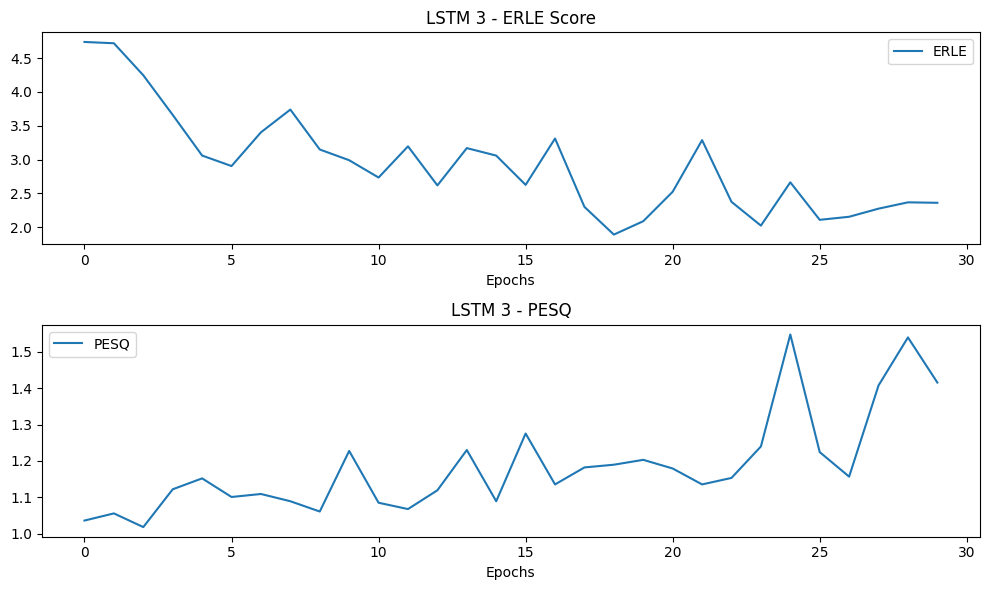

In [19]:
plt.figure(figsize=(10, 6)) 

plt.subplot(2,1,1)
plt.plot(erle_arr, label='ERLE')
plt.xlabel("Epochs")
plt.title("LSTM 3 - ERLE Score")
plt.legend()

plt.subplot(2,1,2)
plt.plot(pesq_arr, label='PESQ')
plt.xlabel("Epochs")
plt.title("LSTM 3 - PESQ")
plt.legend()

plt.tight_layout()
plt.show()

In [20]:
torch.save(lstm, "./models/LSTM3.pth")

In [31]:
lstm = torch.load("./models/LSTM3.pth")
lstm = lstm.to('cuda') 
lstm.eval()


LSTM(
  (lstm): LSTM(257, 1024, num_layers=3, batch_first=True)
  (fc): Linear(in_features=1024, out_features=257, bias=True)
)

In [32]:
# Sample i/p and o/p
(combined, near_mag, mixed_mag, far_mag1, far_mag2, phase) = functions.load_files("./data/mixed/1.wav", "./data/far_end/MGJC0_4.wav", "./data/far_end/MJRK0_3.wav", "./data/near_end/FAEM0_1.wav")
combined_input = mixed_mag.transpose(0,1).unsqueeze(0)
combined_input.shape

torch.Size([1, 512, 257])

In [33]:
outputs = model(combined_input.to('cuda')).transpose(1, 2).squeeze(0).detach().cpu().numpy()
functions.to_wave(outputs, phase, filename="LSTM_3", n_fft=512, hop_length=256, sr=16000, write=1)

array([ 7.1744178e-04,  1.7937832e-04,  2.6045140e-04, ...,
       -3.7951743e-06,  5.6803859e-05, -4.6359859e-05], dtype=float32)

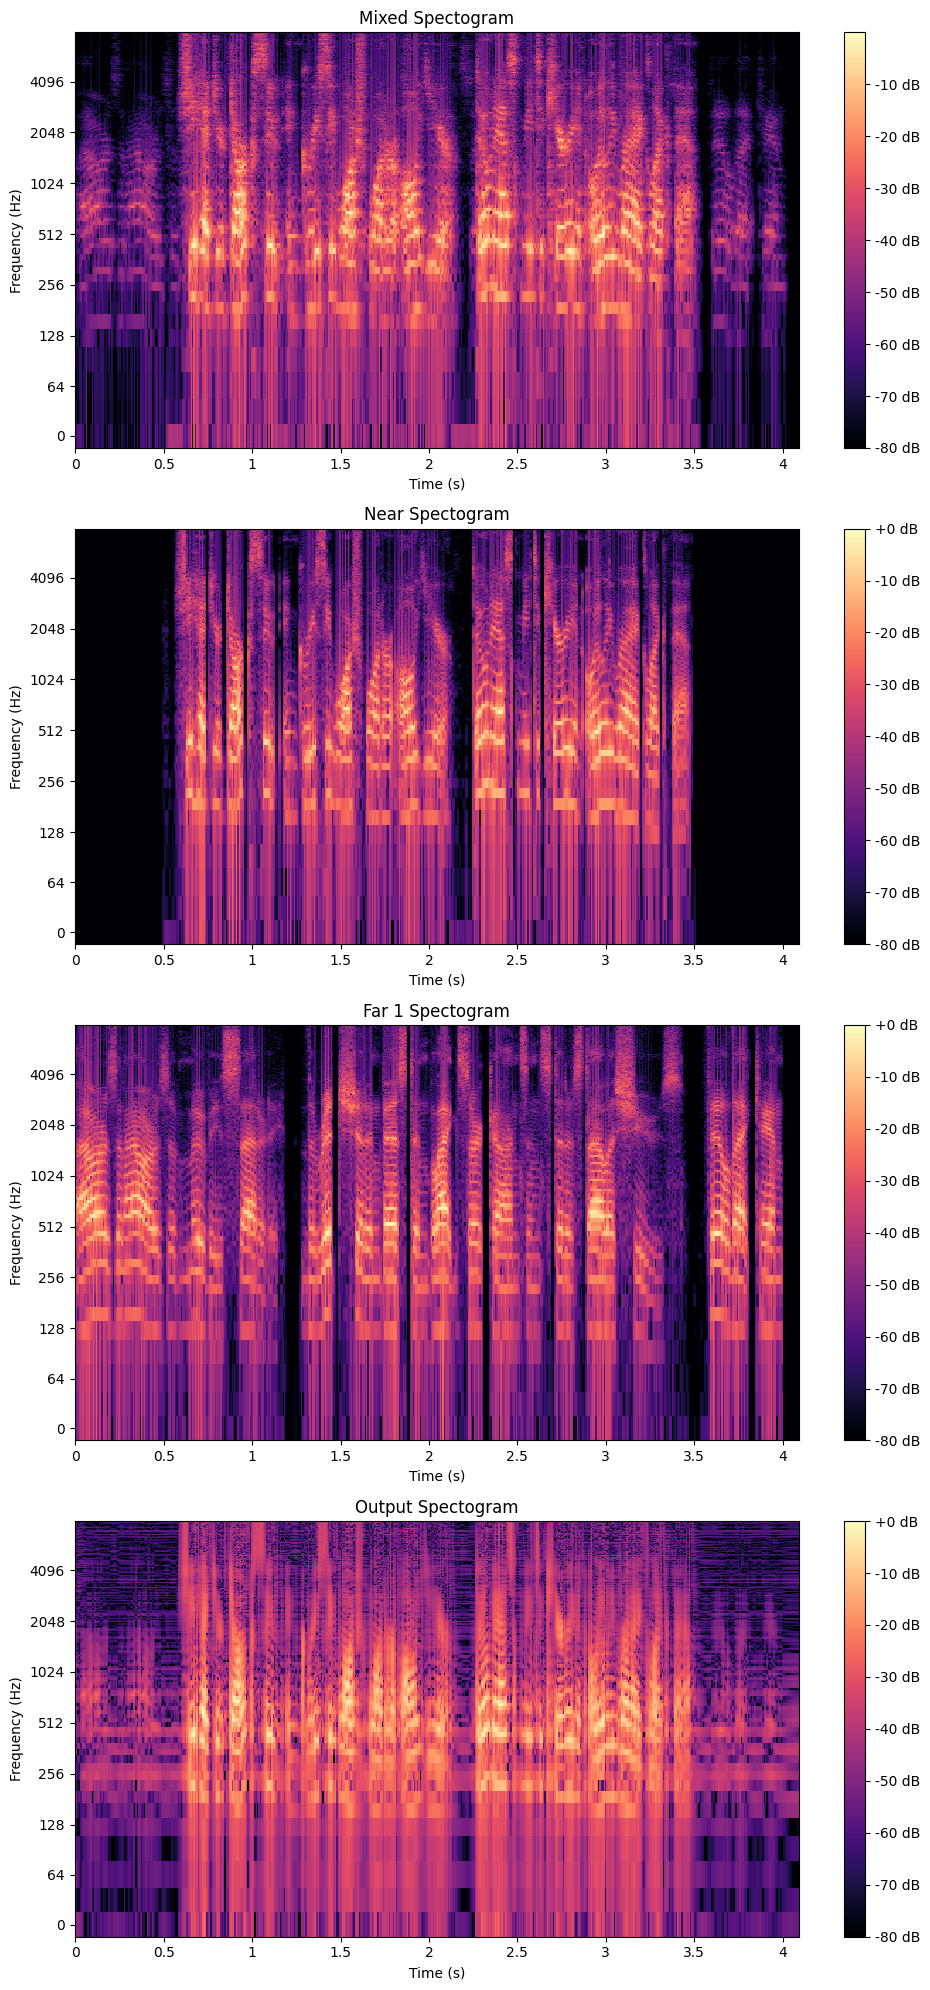

In [34]:
data = [mixed_mag, near_mag, far_mag1, outputs]
titles = ["Mixed Spectogram", "Near Spectogram", "Far 1 Spectogram", "Output Spectogram"]

functions.plot_spectograms(data, titles)

### GRU

In [ ]:
class DCGRU(nn.Module):
    def __init__(self, input_dim=161, hidden_size=512, num_layers=2):
        super(DCGRU, self).__init__()
        self.bidirectional = True
        self.grous = nn.GatedRecurrentUnit(input_dim, hidden_size, num_layers=num_layers,
                                           bidirectional=self.bidirectional)
        # get GRU output to speech file format        
        self.fc = nn.Linear(hidden_size * (2 if self.bidirectional else 1), input_dim)

    def forward(self, x):
        # x with shape [batch_size, seq_length, input_dim]
        output, _ = self.grous(x)
        output = output.contiguous()
        output = output.view(output.size(0), -1)
        output = self.fc(output)
        return output